In [91]:
import collections

Sample = collections.namedtuple('Sample', ['timestamp', 'gnss_easting', 'gnss_northing', 'odom_drive', 'odom_steer', 'lidar'])

In [92]:
def read_log(file):
  result = []
  for line in file:
    sample = line.split()
    result.append(Sample(
        float(sample[0]), 
        float(sample[1]), 
        float(sample[2]), 
        float(sample[3]), 
        float(sample[4]), 
        list(map(lambda s: float(s), sample[5::]))
        ))
  return result

In [93]:
import math
WHEELBASE_LENGTH = 0.32
Pose = collections.namedtuple('Pose', ['x', 'y', 'theta'])
def parse_odometry(log):
  poses = [Pose(0.0, 0.0, 0.0)]
  prev_samp = log[0]
  for samp in log[1::]:
    # https://thomasfermi.github.io/Algorithms-for-Automated-Driving/Control/BicycleModel.html
    dt = samp.timestamp - prev_samp.timestamp
    poses.append(
      Pose(
        poses[-1].x + samp.odom_drive * dt * math.cos(poses[-1].theta), 
        poses[-1].y + samp.odom_drive * dt * math.sin(poses[-1].theta), 
        poses[-1].theta + samp.odom_drive * dt * math.tan(samp.odom_steer) * WHEELBASE_LENGTH
        )
      )
  return poses


In [94]:
Trans = collections.namedtuple('Trans', ['x', 'y'])

def parse_lidar(path, log):
  detections = []
  for (samp, pose) in zip(log, path):
    for (i, radius) in enumerate(samp.lidar):
      theta = pose.theta + ((float(i) / len(samp.lidar)) * 2 * math.pi)
      x = math.cos(theta) * radius
      y = math.sin(theta) * radius
      detections.append(
        Trans(
          pose.x + x,
          pose.y + y
        )
    )
  return detections

[Sample(timestamp=0.0, gnss_easting=0.05, gnss_northing=0.0, odom_drive=0.5, odom_steer=0.1, lidar=[]), Sample(timestamp=0.1, gnss_easting=0.09997542426343176, gnss_northing=0.0015674723889104035, odom_drive=0.5, odom_steer=0.1, lidar=[]), Sample(timestamp=0.2, gnss_easting=0.1498771454758319, gnss_northing=0.0047008762951908966, odom_drive=0.5, odom_steer=0.1, lidar=[]), Sample(timestamp=0.30000000000000004, gnss_easting=0.1996561087750077, gnss_northing=0.009397131490482973, odom_drive=0.5, odom_steer=0.1, lidar=[]), Sample(timestamp=0.4, gnss_easting=0.24926337997341194, gnss_northing=0.015651621417565164, odom_drive=0.5, odom_steer=0.1, lidar=[]), Sample(timestamp=0.5, gnss_easting=0.29865019366189094, gnss_northing=0.0234581977285648, odom_drive=0.5, odom_steer=0.1, lidar=[]), Sample(timestamp=0.6000000000000001, gnss_easting=0.3477680011475186, gnss_northing=0.032809186328965116, odom_drive=0.5, odom_steer=0.1, lidar=[]), Sample(timestamp=0.7000000000000001, gnss_easting=0.396568

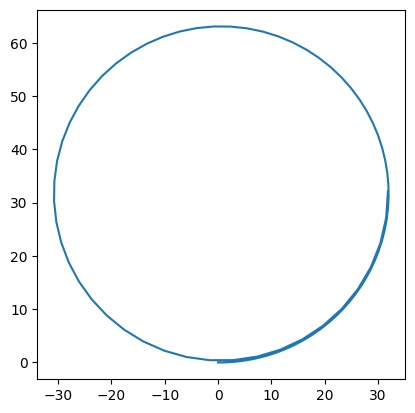

In [99]:
import matplotlib.pyplot as plt
test_log = read_log(open('./test_log.log', 'r'))
print(test_log)
odometry = parse_odometry(test_log)
print(odometry)
detections = parse_lidar(odometry, test_log)
print(detections)

# show odo
fig, ax1 = plt.subplots()
ax1.plot(list(map(lambda pose: pose.x, odometry)), list(map(lambda pose: pose.y, odometry)))
ax1.scatter(list(map(lambda trans: trans.x, detections)), list(map(lambda trans: trans.y, detections)), color='red')
ax1.set_aspect('equal')
plt.show()